Попробуем обучим Random Forest на уменьшенном количестве признаков с ограниченным количеством данных.

In [6]:
# Импортируем банные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error

# Скачивание данныъх
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")

# Разбиваем на трейн тест
df_train = data.iloc[:-48]
df_test = data['aqi'].iloc[-48:]
df = data[["CO_Concentration", "PM10_Concentration", "PM2.5_Concentration"]]

INFO:pycodestyle:12:80: E501 line too long (130 > 79 characters)


In [7]:
# Преобразуем исходнные данные
data1 = df_train[["aqi", "CO_Concentration", "PM10_Concentration", "PM2.5_Concentration"]]
df_y = data1[["aqi"]]
df_x = data1[["CO_Concentration", "PM10_Concentration", "PM2.5_Concentration"]]
dfx = DataFrame()
for i in df_x:
    dfx[f'{i}'] = df_x[i].shift(1)
for i in df_x:
    dfx[f'{i}2'] = df_x[i].shift(2)
dfy = DataFrame(df_y)
frames = [dfy, dfx]
results = concat(frames, axis=1)
results = results.dropna()

y = DataFrame(results['aqi'])
x = results
del x['aqi']

INFO:pycodestyle:2:80: E501 line too long (90 > 79 characters)


In [8]:
# Обучим модель
regr = RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)
regr.fit(x, y)

<ipython-input-8-b42079db1af5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x, y)


RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)

In [13]:
# Выполним предсказание на 48 дней вперед относительно начала тестовой части:
y = DataFrame(df_test)
x = df[-48:].fillna(df_test.mean())
testx = DataFrame()
for i in x:
    testx[f'{i}'] = x[i].shift(1)
for i in x:
    testx[f'{i}2'] = x[i].shift(2)

x = testx
samples = []

for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    forecasts = []

    for t in range(10000):
        tree = regr.estimators_[np.random.randint(len(regr.estimators_))]
        pred = tree.predict(Xf)[0]
        forecasts.append(pred)

        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

    samples.append(forecasts)

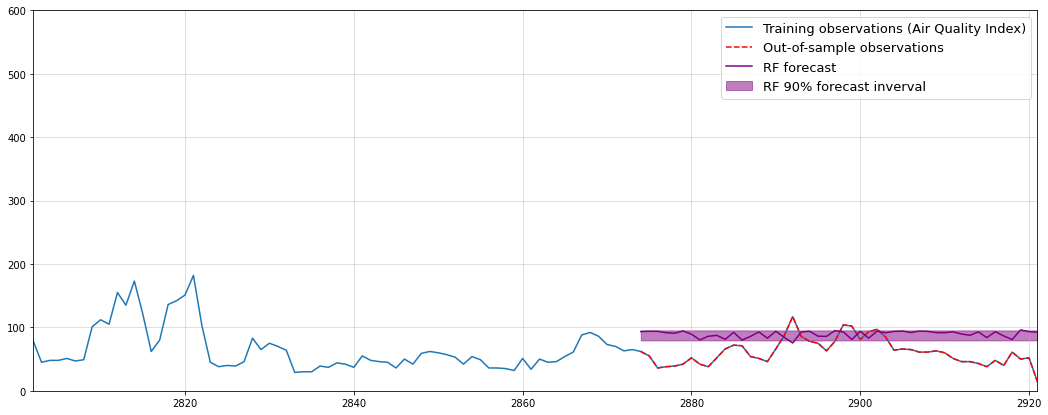

INFO:pycodestyle:11:80: E501 line too long (84 > 79 characters)
INFO:pycodestyle:12:80: E501 line too long (91 > 79 characters)
INFO:pycodestyle:13:80: E501 line too long (96 > 79 characters)
INFO:pycodestyle:15:80: E501 line too long (134 > 79 characters)


In [12]:
# Найдем квантили для формрования доверительного интервала
means_forest = samples
lowers_forest = np.quantile(samples, 0.05, 1)
uppers_forest = np.quantile(samples, 0.95, 1)

# Визуализируем полученные данные
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(data['aqi'].iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(df_test.iloc[-120:], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.iloc[-120:].index, means_forest[-1][-48:], color="purple", label="RF forecast")

plt.fill_between(df_test.iloc[-120:].index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [14]:
# Найдем ошибку
error = mean_absolute_error(df_test.iloc[-120:], means_forest[-1][-48:])
error

31.66834297975873

### Попробуем обучить лес на ограниченных исходных данных (150 дней)


In [15]:
# Формируем ограниченный тренировочный и тестовый датасет
df_train = data.iloc[450:600]
df_test = data['aqi'].iloc[100:200]

# Преобразуем исходнные данные
data2 = df_train[["aqi", "CO_Concentration", "PM10_Concentration", "PM2.5_Concentration"]]
df_y = data2[["aqi"]]
df_x = data2[["CO_Concentration", "PM10_Concentration", "PM2.5_Concentration"]]
dfx = DataFrame()
for i in df_x:
    dfx[f'{i}'] = df_x[i].shift(1)
for i in df_x:
    dfx[f'{i}2'] = df_x[i].shift(2)
dfy = DataFrame(df_y)
frames = [dfy, dfx]
results = concat(frames, axis=1)
results = results.dropna()

y = DataFrame(results['aqi'])
x = results
del x['aqi']

INFO:pycodestyle:6:80: E501 line too long (90 > 79 characters)


In [16]:
# Обучим модель
regr = RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)
regr.fit(x, y)

<ipython-input-16-b42079db1af5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x, y)


RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)

In [21]:
# Выполним предсказание на 48 дней вперед относительно начала тестовой части:
y = DataFrame(df_test)
x = df[100:200].fillna(df.mean())
testx = DataFrame()
for day in x:
    testx[f'{day}'] = x[day].shift(1)
for day in x:
    testx[f'{day}2'] = x[day].shift(2)

x = testx
samples = []

for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    forecasts = []

    for t in range(10000):
        tree = regr.estimators_[np.random.randint(len(regr.estimators_))]
        pred = tree.predict(Xf)[0]
        forecasts.append(pred)

        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

    samples.append(forecasts)

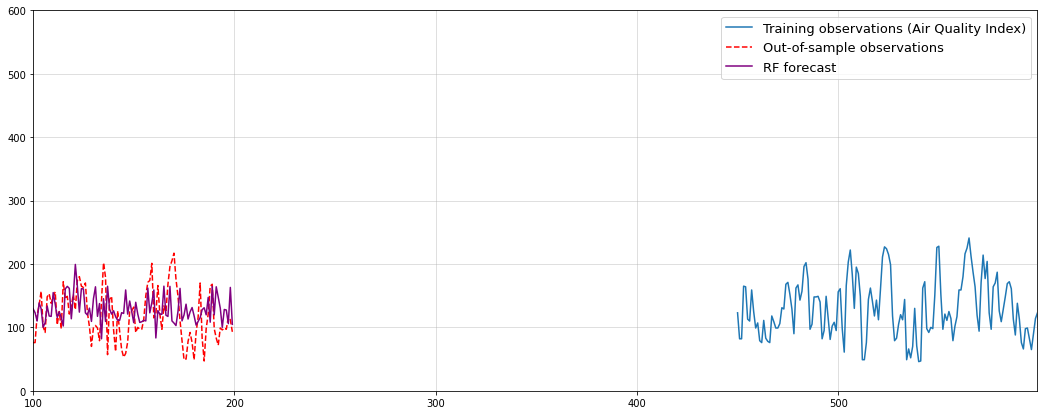

INFO:pycodestyle:13:80: E501 line too long (87 > 79 characters)


In [19]:
# Найдем квантили для формирования доверительного интервала
means_forest = samples
lowers_forest = np.quantile(samples, 0.05, 1)
uppers_forest = np.quantile(samples, 0.95, 1)

# Визуализируем предсказания
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df_y[:400], label="Training observations (Air Quality Index)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest[-1][100:200], color="purple", label="RF forecast")

plt.legend(fontsize=13)
plt.margins(x=0)

In [20]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest[-1][100:200])
error

35.632636993120435

Лучший результат : <br>
 полные данные - MAE 31 <br>
ограниченные данные - MAE 35.8 <br>
В рамках задачи, обучение на "будущих" данных и предсказание прошедших несущественно и допускается.
